### Custom Homography Tutorial

Here, we will go over how to create custom Homography transformations to images on an in-depth level. 

Original Tutorial by Isaac Chung and Joshua Garcia-Kimble

#### Sources

1. Tutorial on making plots interactive: https://www.geeksforgeeks.org/make-3d-interactive-matplotlib-plot-in-jupyter-notebook/
2. Explanation of how homographies work: https://docs.opencv.org/4.x/d9/dab/tutorial_homography.html
3. 2x2 Image Transformations Explanation Video: https://youtu.be/K2XLXlyPqCA
4. 3x3 Image Transformations Explanation Video: https://www.youtube.com/watch?v=B8kMB6Hv2eI
5. Computing Homographies for Image Stitching Video: https://www.youtube.com/watch?v=l_qjO4cM74o
6. How to create 3D Surfaces Tutorial: https://www.geeksforgeeks.org/three-dimensional-plotting-in-python-using-matplotlib/
7. Image Warping without `Skimage`: https://stackoverflow.com/questions/70311373/applying-homography-transformation-in-python-without-using-opencv
8. Applying homographies with OpenCV: https://learnopencv.com/homography-examples-using-opencv-python-c/
9. Homographies with Image Processing: https://mattmaulion.medium.com/homography-transform-image-processing-eddbcb8e4ff7#:~:text=Homography%2C%20also%20referred%20to%20as,in%20a%20homogenous%20coordinates%20space

### Import the required Python libraries for this notebook.

In [1]:
# Required commands to show interactive 3D plots
%matplotlib notebook
%matplotlib widget
%matplotlib inline

In [5]:
# Required libraries for our notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import functools
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import normalize

import math
import numpy.matlib as npm
import cv2
import skimage

ModuleNotFoundError: No module named 'skimage'

### Let's start by creating some functions that will allow us to apply image transformations on custom images!

The functions below allow us to transform objects of interest from a 2D space to a 3D space, back to a 2D space. This is allows us to transform objects so that we can view them from a different perspective (i.e. rotation, warping, etc.) or point in the plane. 

We will perform these transformations using the idea of **homographies**. Let us first go over what homographies are and why they are useful.



#### Homographies
1. They are transformations that describe the relationship between two different images of the same scene, just taken from different viewpoints/perspectives.

2. They are represented as matrices where each element of the matrix represents a transformation parameter that relates the coordinates of points in one image to another.

3. We represent points in a scene using homogeneous coordinates, which are points that encode a representation in both 2D and 3D space.

4. The homography matrix represents the mapping or perspective change between points in one image to their corresponding points in another image.

5. They are used in various different computer vision fields such as image stitching (where we have multiple images of a scene and we align these images together), camera calibration (estimating intrinsic and extrinsic parameters to align camera POVs), and augmented reality (overlay virtual objects into the real world).

##### Additional information about Homographies are provided here:
1. homography_example.pynb file in the same directory.
2. OpenCV Guide on Homographies: https://docs.opencv.org/4.x/d9/dab/tutorial_homography.html
3. Image Processing using Homographies: https://mattmaulion.medium.com/homography-transform-image-processing-eddbcb8e4ff7
4. Another perspective on Homographies: https://www.sciencedirect.com/topics/engineering/homography
5. Object Tracking using Homographies: https://www.geeksforgeeks.org/python-opencv-object-tracking-using-homography/

We consider a range of different transformations that we can apply to an image to mimic the effects of utilizing the imported `Skimage` transformation functions.

### Now, let's define functions that will help us plot these objects utilizing homographies.

Here are some extra sources you can use to get more insight on some of the functions provided below:

1. More information on ColorMaps: https://matplotlib.org/stable/api/_as_gen/matplotlib.colors.LinearSegmentedColormap.html
2. How to articulate and compute meshgrids: https://www.geeksforgeeks.org/numpy-meshgrid-function/#:~:text=meshgrid%20function%20is%20used%20to,is%20somewhat%20inspired%20from%20MATLAB.

In [6]:
def get_rid_of_z_dimension(array_3D):
    '''
        This function removes the last dimension of a 3D input space to reflect the 3D -> 2D image transformation notion. 
        Recall that the overall tranformation requires an object to go through 2D -> 3D -> 2D spaces, so this function actually 
        performs the second half of this transition.

        Params: array_3D (a 3D tensor array of the form nx3).
        Returns: a 2D array of the same array (minus the last dimnesion) in the form nx2.
    '''

    return np.delete(array_3D, -1, axis=-1)


def plot_tensor(tensor):
    '''
        This function plots a tensor that can be in 2D or 3D form.

        Params: tensor (a 2D or 3D tensor - can be whichever).
        Returns: None (but plots the input tensor).
    '''

    # Plot color points onto a 3D space
    cmap_colors = [(0, 'red'), (1, 'blue'), (1, 'green')]
    custom_cmap = LinearSegmentedColormap.from_list('custom', cmap_colors)

    num_dimensions = 2
    num_points = int(math.sqrt(tensor.shape[0]))

    # Custom threshold
    lowest_color_value = 0.2
    highest_color_value = 0.8

    x_color = np.linspace(lowest_color_value, highest_color_value/num_dimensions, num_points)
    y_color = np.linspace(lowest_color_value, highest_color_value/num_dimensions, num_points)

    # Meshgrid allows us to compute gradients
    X_color, Y_color = np.meshgrid(x_color, y_color)

    # Combine data for both dimensions into a single variable
    combined_data = X_color + Y_color  # You can use a different combination as needed

    # Apply the custom colormap to the combined data
    color = custom_cmap(combined_data)

    # Make sure the color is in the right form (num of data points x 4), so we have a 
    # color for each datapoint
    color_new = color.reshape((-1, 4))


    if len(tensor.shape) == 2:
        # Create a figure and axis
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')


        ######################################################
        ##############$$     3D Tensor     ###################
        ######################################################

        if tensor.shape[-1] == 3:

            # Display the computed points
            ax.scatter(tensor[:,0], tensor[:,1], tensor[:,2], c=color_new, cmap=custom_cmap, s=50, marker='o')

            # # Set the 3D axis limits so we can view everything
            # min_val = min(tensor.flatten())
            # max_val = max(tensor.flatten())

            # ax.set_xlim(min_val, max_val)
            # ax.set_ylim(min_val, max_val)
            # ax.set_zlim(min_val, max_val)

            plt.show()


        ######################################################
        ##############$$     2D Tensor     ###################
        ######################################################

        elif tensor.shape[-1] == 2:
            # Create a figure and axis
            fig = plt.figure()
            ax = fig.add_subplot(111)
            
            # Display the computed points
            ax.scatter(tensor[:,0], tensor[:,1], c=color_new, cmap=custom_cmap, s=50, marker='o')

            # # Set the 3D axis limits so we can view everything
            # min_val = min(tensor.flatten())
            # max_val = max(tensor.flatten())

            # ax.set_xlim(min_val, max_val)
            # ax.set_ylim(min_val, max_val)

            plt.show()
    return

### Next, let's define functions that illustrate the specific transformations we can apply to our input image(s)!

#### Rotation

In [25]:
def create_rotation_matrix_clockwise(degrees):
    '''
        This function creates a rotation matrix to which we can apply to images in order to rotate
        them counter-clockwise by some degree.

        Params: degrees (the number of degrees to specify the extent of our rotation).
        Returns: a matrix that represents the rotation of an image.
    '''

    radians = math.radians(degrees)     # Convert degrees to radians

    cos_theta = math.cos(radians)
    sin_theta = math.sin(radians)

    # Compute the rotation matrix
    rotation_matrix = np.array([[cos_theta, -sin_theta, 0],
                                [sin_theta, cos_theta, 0],
                                [0, 0, 1]])

    return rotation_matrix

#### Translation

In [26]:
def create_translation_matrix(dx, dy, dz = 0, dims = 2):
    '''
        This function creates a translation matrix to which we can apply to images by specifying the extent of 
        the image's x, y, and z displacement.

        Params: dx (the change in displacement in the x-direction).
                dy (the change in displacement in the y-direction).
                dz (the change in displacement in the z-direction).
                dims (the number of dimensions for our image of interest).
        Returns: a matrix that represents the translation of an image.
    '''
    
    # 2D Image Translation
    if dims == 2:
        translation_matrix = np.array([[1, 0, dx], 
                                       [0, 1, dy], 
                                       [0, 0, 1]])
    
    # 3D Image Translation
    elif dims == 3:
        translation_matrix = np.array([[1, 0, 0, dx],
                                       [0, 1, 0, dy],
                                       [0, 0, 1, dz], 
                                       [0, 0, 0, 1]])

    return translation_matrix

#### Scale

In [27]:
def create_scale_matrix(scaleX, scaleY, dims = 2):
    '''
        This function creates a scale matrix to which we can can apply to images by specifying the 
        amount of scale to the image's x and y axes.

        Params: scaleX (the amount of scale in the image's x axis).
                scaleY (the amount of scale in the image's y axis).
                dims (the number of dimensions for our image of interest).
        Returns: a matrix that represents the scale of an image.
    '''

    # Directly compute the scale matrix
    scale_matrix = np.array([[scaleX, 0, 0],
                             [0, scaleY, 0],
                             [0, 0, 1]])

    return scale_matrix

#### Skew

In [28]:
def create_skew_matrix(skew_amt, dims = 2):
    '''
        This function creates a skew matrix to which we can apply to images by specifying
        the extent of the skew in the horizontal and vertical directions.

        Params: skew_amt (the amount of skew specified as a numerical value).
                dims (the number of dimensions for our image of interest).
        Returns: a matrix that represents the skew of an image (one for horizontal, one for vertical).
    '''

    # Horizontal Skew
    skew_matrix_X = np.array([[1, skew_amt, 0],
                              [0, 1, 0],
                              [0, 0, 1]])
    
    # Vertical Skew
    skew_matrix_Y = np.array([[1, 0, 0],
                              [skew_amt, 1, 0],
                              [0, 0, 1]])
    
    return skew_matrix_X, skew_matrix_Y

#### Warp

In [29]:
def create_warp_matrix(warp_x, warp_y, dims=2):
    '''
        This function creates a warp matrix to which we can apply to images by specifying
        the amount of warping in the x and y axes.

        Params: warp_x (the amount of warping in the horizontal direction).
                warp_y (the amount of warping in the vertical direction).
                dims (the number of dimensions for our image of interest).
        Returns: a matrix that represents the warping of an image.
    '''

    # Compute the warp matrix
    warp_matrix = np.array([[1, 0 , 0], 
                            [0, 1, 0],
                            [warp_x, warp_y, 1]])
    
    return warp_matrix

### We have our functions that apply various different transformations to images. Now, we can create functions that apply a transformation to an image! 

This makes it easier to read and understand what is going on rather than simplying creating long, chunked-up pieces of code.

In [50]:
def apply_transformation(tensor, transformation):
    '''
        Applies a transformation to a particular tensor (image tensor) and returns the transformed tensor.

        Params: tensor (nx2 or nx3 tensor that represents our image).
                transformation (a specific transformation matrix specified by the transformation functions defined above).
        Returns: another version of the input tensor, this time with the applied transformation; should retain initial dimensions.
    '''

    # Print for debugging purposes
    print("transformation.shape: ", transformation.shape)
    print("input.shape: ", tensor.shape)

    return np.matmul(transformation, tensor.T).T

In [22]:
def create_affine_transformation():
    '''
        This function creates an affine transformation matrix that can be applied to images.
        It takes in individual transformation matrices, combines their effects, and applies the resulting
        matrix to images of interest.

        Params: None (instead, the functions that generate individual transformation matrices are called).
        Returns: an affine transformation matrix with the combined effects of the individual transformations.
    '''
    
    # Rotation
    rotation_matrix = create_rotation_matrix_clockwise(45)      # Degrees are chosen by the user

    # Translation
    translation_matrix = create_translation_matrix(5, 10)       # dx, dy, and dz are chosen by the user

    # Scale
    scaling_matrix = create_scale_matrix(1, 2)                  # scaleX, scaleY are chosen by the user

    # Skew
    skew_matrix_X, skew_matrix_Y = create_skew_matrix(0)        # Skew amount is chosen by the user


    # Debugging print statements below

    # print(np.matmul(rotation_matrix, translation_matrix))

    # print("Rotation matrix")
    # print(rotation_matrix)
    # print("Translation matrix")
    # print(translation_matrix)
    # print("scaling matrix")
    # print(scaling_matrix)
    # print("skew matrices")
    # print(skew_matrix_X)
    # print(skew_matrix_Y)

    # print(rotation_matrix.shape)
    # print(translation_matrix.shape)
    # print(scaling_matrix.shape)
    # print(skew_matrix_X.shape)
    # print(skew_matrix_Y.shape)


    # Combine the individual effects of transformations to create affine effect
    affine_transformation = functools.reduce(np.matmul, [translation_matrix, skew_matrix_X, scaling_matrix, rotation_matrix])

    return affine_transformation

Here are some sources on how the **functools** module works in Python:

1. https://www.geeksforgeeks.org/functools-module-in-python/
2. https://docs.python.org/3/library/functools.html
3. https://www.scaler.com/topics/reduce-function-in-python/#

We will only be using the functools.reduce() method which is a higher-order function from functional programming that in our case, multiplies a set of matrices. 

In [7]:
def create_homography_transformation():
    '''
        This function creates a custom homography matrix (3x3) by combining the effects of the rotation, translation, 
        scaling, skew, and warping transformations.

        Notice that this function is the same as create_affine_transformation() but with the
        warping (which accounts for the perspective change). 
        
        Note: the input values for each of these transformations must be inputted manually by the user to receive their
              desired image transformation (aka affine transformation matrix).
    '''
    
    # Rotation
    rotation_matrix = create_rotation_matrix_clockwise(90)

    # Translation
    translation_matrix = create_translation_matrix(0, 0)

    # Scale
    scaling_matrix = create_scale_matrix(1, 1)

    # Skew
    skew_matrix_X, skew_matrix_Y = create_skew_matrix(0)

    # Warp
    warp_matrix = create_warp_matrix(1, 3)

    # Combine the individual effects of transformations to create homography effect
    # Make sure order of multiplication is right since matrices aren't communicative
    homography = functools.reduce(np.matmul, [translation_matrix, skew_matrix_X, scaling_matrix, rotation_matrix, warp_matrix])

    return homography

#### Let's try using the functions we just created in a simple application! 

Here we will create an affine transformation matrix and a homography matrix by combining the previous transforms we've been working with.

In [31]:
# The number of points along the x and y directions in our plane
num_points = 50

# Set the boundaries of the square we are creating (these constants are defined by the user)
min_x = -1
max_x = 1

min_y = -1
max_y = 1

z_value = 1
z_value_transformation = 2

# Create a grid of x and y values that will be the points of our "plane"
x_plane = np.linspace(min_x, max_x, num_points)
y_plane = np.linspace(min_y, max_y, num_points)

X_grid, Y_grid = np.meshgrid(x_plane, y_plane)
X_grid = X_grid.reshape((-1, 1))
Y_grid = Y_grid.reshape((-1, 1))
Z_grid = np.full(X_grid.shape, z_value)

# Obtain the generated points in a 3D space
points_3D_original = np.concatenate((X_grid, Y_grid, Z_grid), axis=1)

# Obtain the 2D points by removing the third dimension
points_2D_original = get_rid_of_z_dimension(points_3D_original)

# Create our custom transformation matrices
affine_transformation = create_affine_transformation()
homography = create_homography_transformation()
print(f'Our homography matrix:')
print(homography)

# Apply our affine transformation to the 3D object
points_3D_affine = apply_transformation(points_3D_original, affine_transformation)
print("points_3D_original.shape", points_3D_original.shape)

# Apply our homography transformation to the 3D object
points_3D_homography = apply_transformation(points_3D_original, homography)
homography_determinant = np.linalg.det(homography)                              # Compute the determinant of the matrix (lin alg)
print(f"Our homography's determinant: {homography_determinant}")

# Remove the third dimension of our 3D affine transformation
points_2D_affine = get_rid_of_z_dimension(points_3D_affine)

# Remove the third dimension of our 3D homography transformation
points_2D_homography = get_rid_of_z_dimension(points_3D_homography)

Our homography matrix:
[[ 6.123234e-17 -1.000000e+00  0.000000e+00]
 [ 1.000000e+00  6.123234e-17  0.000000e+00]
 [ 1.000000e+00  3.000000e+00  1.000000e+00]]
transformation.shape:  (3, 3)
input.shape:  (2500, 3)
points_3D_original.shape (2500, 3)
transformation.shape:  (3, 3)
input.shape:  (2500, 3)
Our homography's determinant: 1.0


#### We cannot plot these transformations just yet since we haven't defined a way for us to retrieve the homogeneous coordinates (with a z-dimension) of an image from an image plane. 

We need to be able to apply our homography transformations somehow. 

#### Let's create a function that can allow us to apply these homogeneous coordinates to our image(s)!

In [8]:
DEFAULT_HOMOGENOUS_COORDINATE = 1           # User-selected homogeneous coordinate (default)

def get_homogenous_img_coordinates(img):
    '''
        This function derives the homogeneous coordinates of an image or particular object of interest in order to
        apply homography transformations. Essentially it adds a z-dimension with the default value of 1. 

        Params: img (an image tensor containing the object of interest).
        Returns: the new image coordinates of the input image as a tensor after adding in the homogeneous coordinates.
    '''

    (width, height) = img.shape
    X, Y = np.mgrid[0:width, 0:height]      # Dense mesh-grid (returned output has same dims -- X and Y)

    X = X.reshape((-1, 1))
    Y = Y.reshape((-1, 1))

    homogenous_coordinates = np.full(X.shape, DEFAULT_HOMOGENOUS_COORDINATE)

    # Add the z-coordinate to the end of the image matrix/vector
    img_coordinates = np.concatenate((X, Y, homogenous_coordinates), axis=1)
    
    print("img_coordinates.shape: ",img_coordinates.shape)
    return img_coordinates

#### Now that we have our newly generated image coordinates, we can create functions that will plot our new image in a 3D or 2D space.

In [9]:
SCATTER_DOT_SIZE = 5

def plot_image_3D(img_coordinates, img_color):
    '''
        This function plots an image into a 3D plane.
        This function depends on deriving the new image coordinates (after applying the homography coordinates to the image).

        Params: img_coordinates (the image coordinates including the homography coordinates at its end).
                img_color (the color of the image that we desire).
        Returns: None (but displays the image onto a 3D plane).
    '''

    cmap_colors = [(1, 'red'), (1, 'blue'), (1, 'green')]  # Colors for the combined dimension
    custom_cmap = LinearSegmentedColormap.from_list('custom', cmap_colors)

    # Prepare the plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Fill in the image onto the 3D plane point-by-point
    ax.scatter(img_coordinates[:,0],img_coordinates[:,1], img_coordinates[:,2], c=img_color, cmap=plt.cm.gray, s=SCATTER_DOT_SIZE) # lineWidth parameter causes errors (DON'T USE!)
    plt.show()


def plot_image_2D(img_coordinates, img_color):
    '''
        This function plots an image into a 2D plane.
        This function depends on deriving the new image coordinates (after applying the homography coordinates to the image).
        It ignores the z-coordinate. 

        Params: img_coordinates (the image coordinates including the homography coordinates at its end).
                img_color (the color of the image that we desire).
        Returns: None (but displays the image onto a 2D plane).
    '''

    cmap_colors = [(1, 'red'), (1, 'blue'), (1, 'green')]  # Colors for the combined dimension
    custom_cmap = LinearSegmentedColormap.from_list('custom', cmap_colors)

    # Prepare the plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # Fill in the image onto the 3D plane point-by-point
    ax.scatter(img_coordinates[:,0],img_coordinates[:,1], c=img_color, cmap=plt.cm.gray, s=SCATTER_DOT_SIZE) # lineWidth parameter causes errors (DON'T USE!)
    plt.show()

#### We have shown how we can plot images onto a new plane after incorporating homography coordinates to the image itself.

#### However, if we want to analyze the projection process on a deeper level, we can't really see that by simply just plotting image tensors. To tackle this problem, we can create functions that help us project these adjusted image coordinates onto a plane, specifically in a 2D space!

#### Projecting a tensor onto a plane requires normalization of the tensor itself, which we will define first.

TODO: delete this function because we don't use it so it's presence is confusing

In [10]:
def get_normal_vector(plane_coordinates):
    '''
        This function computes the coordinates of a normal vector in a particular plane.

        Params: plane_coordinates (3 points chosen from a plane of interest).
        Returns: a normal unit vector within the same input plane.
    '''

    # We compute the equation for the normal vector of a plane from 3 points
    # by using the cross product
    coord1 = plane_coordinates[1,:]
    coord2 = plane_coordinates[2,:]
    coord3 = plane_coordinates[3,:]
    
    vector1 = coord1-coord2 
    vector2 = coord2-coord3

    normal = np.cross(vector1, vector2)                     # Take the cross product of two vectors
    normal_unit_vec = normal / np.linalg.norm(normal)       # Normalize the cross product (into a unit vector)
    return normal_unit_vec

#### With this function, we can now retrieve a 2D projection using the homogeneous coordinates we derived earlier.

In [11]:
def project_to_2D(homog_coord):
    '''
        This function retrieves a 2D projection of a particular image in a 2D plane.
        We can simply perform this operation by dividing the homogeneous coordinates by the z-dimension. 
        
        Note: we are assuming to project onto a plane where the rays would go through the origin
              and there's only one set of planes where we can do this (the planes centered around and facing the origin).

              We also expect the input homogeneous coordinates to be of the form (N*M)x3 where N is the number of rows
              and M is the number of columns of the image. Hence, the resulting projection should have N*M rows and 3 columns.
            
        Params: the homogeneous coordinates of an image.
        Returns: a 2D projection vector of our image.
    '''
    
    Z_DIM_INDEX = 2

    z_dimension = homog_coord[:,Z_DIM_INDEX].reshape(-1, 1)
    projection_2D = homog_coord / z_dimension     # Simply divide the homogeneous coords by the z-dimension

    return projection_2D

#### Great! Now, we have everything we need to run some examples using the functions we just created.

You should be able to see a zebra image in the images folder under the current directory. If not, you can import your own image that you would like to test. It should work with any images!

In [176]:
# Import image of interest
img = cv2.imread('images/Zebra_small.png')  # You can change the image of your choosing
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convert to grayscale

# Resize the img if needed
resize_factor = 1.0                         
img = cv2.resize(img, (int(img.shape[0] * resize_factor), int(img.shape[1] * resize_factor)))

# Make the image of homogenous coordinates
img_homog_coords = get_homogenous_img_coordinates(img)
img_color_map = img.flatten()

img_coordinates.shape:  (64500, 3)


In [52]:
# Create affine transformation matrix and homography matrix
affine_transformation = create_affine_transformation()
homography = create_homography_transformation()

#apply affine transformation matrix and homography matrix.
img_affine_transformation = apply_transformation(img_homog_coords, affine_transformation)
img_homography = apply_transformation(img_homog_coords, homography)

print("Homography Image Shape: ", img_homography.shape)
print("Homography Image Last Row: ", img_homography[0:20,2])

# Project both transformed images onto 2D plane
img_affine_2D = project_to_2D(img_affine_transformation)
img_homography_2D = project_to_2D(img_homography)

transformation.shape:  (3, 3)
input.shape:  (64500, 3)
transformation.shape:  (3, 3)
input.shape:  (64500, 3)
Homography Image Shape:  (64500, 3)
Homography Image Last Row:  [ 1.  4.  7. 10. 13. 16. 19. 22. 25. 28. 31. 34. 37. 40. 43. 46. 49. 52.
 55. 58.]


transformation.shape:  (3, 3)
input.shape:  (64500, 3)
transformation.shape:  (3, 3)
input.shape:  (64500, 3)


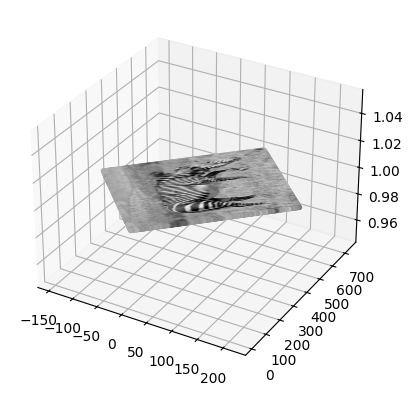

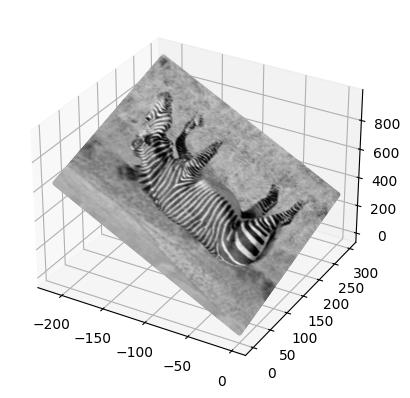

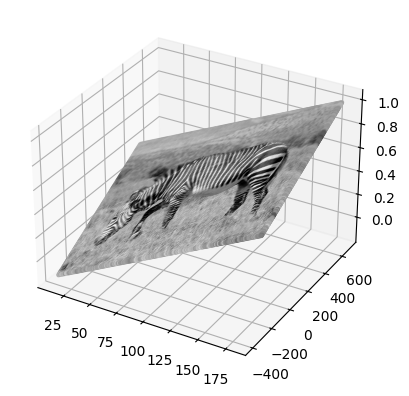

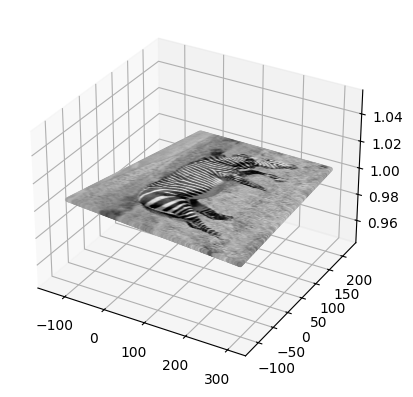

In [53]:
# Manually create an example homography matrix.
transformation_matrix = np.array([[-6.26446174e-02, -6.97407299e-01,  1.80277025e+02],
                                  [-2.13906092e+00, -2.07381974e+00,  6.88118138e+02],
                                  [-2.40391653e-03, -1.96483835e-03,  1.00000000e+00]])

# Manually create another homography matrix
transformation_matrix_2 = np.array([[1.4003, 0.3827, -136.590],
                             [-0.0785, 1.8049, -83.1054],
                             [-0.0003, 0.0016, 1.0000]])

# Apply transformation_matrix and convert to 2D plane
img_transformed = apply_transformation(img_homog_coords, transformation_matrix)
img_transformed_2D = project_to_2D(img_transformed)

# Apply transformation_matrix_2 and convert result
img_transformed2 = apply_transformation(img_homog_coords, transformation_matrix_2)
img_transformed2_2D = project_to_2D(img_transformed2)

# Plot the images in a 3D plane

# First image is what we get by applying the affine transformation (which has no image distortion, 
# only the addition of a z coordinate)
plot_image_3D(img_affine_transformation, img_color_map)

# Second image is what we get from applying the homography matrix we were building 
# from our skew, warp, translation, rotation functions from before
plot_image_3D(img_homography, img_color_map)

# Another application of a homography matrix
plot_image_3D(img_transformed, img_color_map)

# Another application of a homography matrix for good measure. 
plot_image_3D(img_transformed2_2D, img_color_map)


Now let's return to a 2d perspective. 

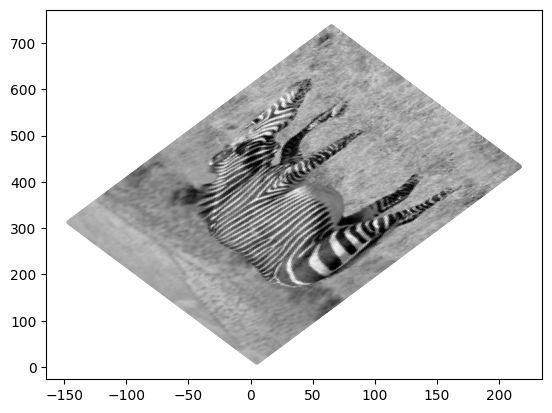

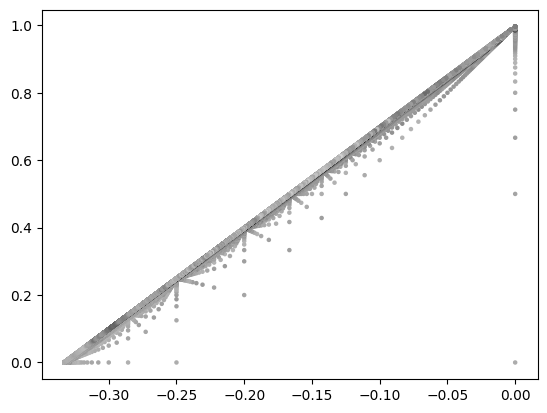

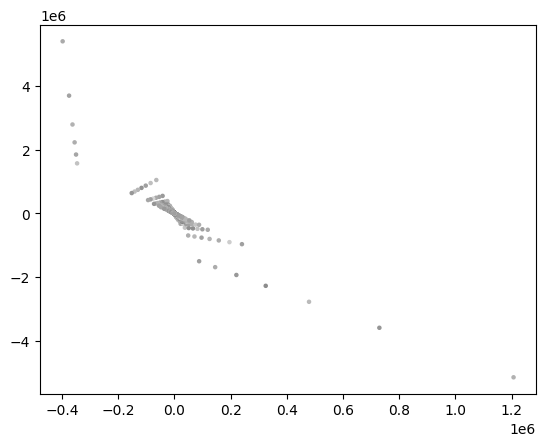

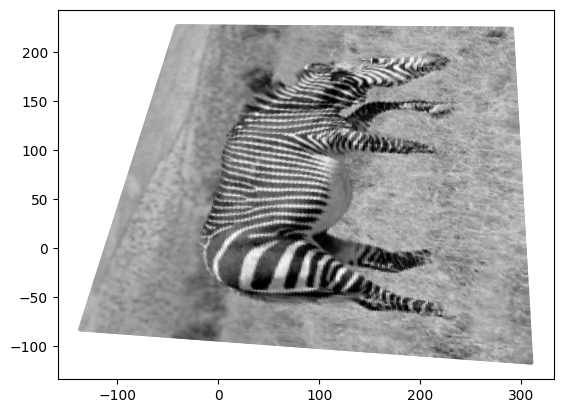

In [54]:
# Plot our images in a 2D plane, in the same order as before.
plot_image_2D(img_affine_2D, img_color_map)
plot_image_2D(img_homography_2D, img_color_map)
plot_image_2D(img_transformed_2D, img_color_map)
plot_image_2D(img_transformed2_2D, img_color_map)

#### So far, we have defined functions that apply a transformation(s) to an image and projects the image from a 2D -> 3D -> 2D space using homographies.

#### Is there another way where we can perform such transformations to achieve the same goal (without using homographies)?

#### We can develop a series of metrics and functions to apply a *Raster Scan Reverse Transform*!

Let us first describe what a Raster Scan Reverse Transform is. Let us split it up into two different terms.



#### Raster Scan

1. Raster scanning is a method used to display or process images where the image is represented as a grid of pixels, and the image is processed row by row or column by column.
2. Usually, the image is scanned from the top-left corner to the bottom-right corner; the image is guaranteed to be scanned sequentially.
3. This is a digital processing technique that allows for the transformation of an image from one coordinate system to another.
4. Raster scanning is more accurate than other transformation methods, less likely to cause distortion(s) in the image, and is usually very fast and efficient.

#### Reverse Transform

1. This transformation is applied to the raster-scanned image in the opposite direction of the original transformation.
2. This performs the inverse operation of the original transformation, aiming to undo its effects...

   (i.e. if we transformed an image from 2D to 3D, we can apply a reverse transform to get the image back to a 2D coordinate system)

3. Raster Scan, on its own, may miss some coordinate points (or "pixels) during its scanning process; in other words, some points in the output 
   space may not get mapped to the points from the input plane. However, the reverse transform ensures that there are no missed points.


##### Additional Sources on Raster Scan (Reverse) Transformations
1. Raster Scan in Computer Graphics: https://www.youtube.com/watch?v=OfjKRZK4olg
2. GeeksForGeeks Explanation of Raster Scan: https://www.geeksforgeeks.org/what-is-raster-scan-display-mechanism/
3. Real-life Applications of Raster Scan: https://academic-accelerator.com/encyclopedia/raster-scan

#### The first step requires retrieving the min and max sequence of cells in order to obtain the limits (or bounding box) of the transformations.

In [55]:
def get_min_and_max(transformation_output):
    '''
        This function retrieves the maximum and minimum coordinates of the transformed image coordinates.
        It outlines the window we are going to operate over. 
        This is a helper function to the reverse transformation method defined below.

        Params: transformation_output (a numpy array - could be 2D or 3D - that represents the coordinates of our transformed image).
        Returns: two x, y coordinates - one representing the minimum x, y pair and the other representing the max x, y pair.
    '''

    # Rows > Cols
    if transformation_output.shape[0] > transformation_output.shape[1]:
        min_x = np.min(transformation_output[:,0]).astype(int)
        max_x = np.max(transformation_output[:,0]).astype(int)

        min_y = np.min(transformation_output[:,1]).astype(int)
        max_y = np.max(transformation_output[:,1]).astype(int)

    # Cols >= Rows
    else:
        min_x = np.min(transformation_output[0,:]).astype(int)
        max_x = np.max(transformation_output[0,:]).astype(int)

        min_y = np.min(transformation_output[1,:]).astype(int)
        max_y = np.max(transformation_output[1,:]).astype(int)
    
    # Return coords in tuple fashion
    min_tuple = (min_x, min_y)
    max_tuple = (max_x, max_y)

    return min_tuple, max_tuple

#### We have the max and min coordinates of our transformed image. Let us define our reverse transformation method using `Raster Scan Reverse Transform`.

In [56]:
import numpy as np

def apply_inverse_transform(point, transform):
    '''
        This function applies the inverse transformation to a given point.

        Params: point     (a tuple representing the point coordinates).
                transform (a numpy array that represents the transformation matrix).
        Returns: transformed point (a tuple representing the transformed point coordinates).
    '''
    # Convert point to homogeneous coordinates (add 1 for z)
    homogeneous_point = np.array([point[0], point[1], 1])

    # Compute the inverse of the transformation matrix
    inverse_transform = np.linalg.inv(transform)

    # Apply the inverse transformation
    transformed_point = inverse_transform.dot(homogeneous_point)

    # Convert back to cartesian coordinates
    transformed_point = (transformed_point[0] / transformed_point[2], transformed_point[1] / transformed_point[2])

    return transformed_point

In [67]:
def raster_scan_reverse_transform(original_image, homogenous_input, homogenous_color_map, transform):
    '''
        This function applies the Raster Scan Reverse Transform to revert the transformation effects of our image.
        Raster scans goes through all the values in the transformed coordinates (as if scanning through a bounding
        box) and applies the reverse transform. By doing so, we obtain a color value at the reverse transform 
        location and we will apply that color value to the coordinate(s) in our output space.

        Params: original_image        (a numpy array representing the coordinates of our original image (hxw)).
                homogeneous_input     (a numpy array representing the coordinates of the original input (hxwx3)).
                homogeneous_color_map (a numpy array that maps a color to each of the indices in the homogeneous input (hxwx1)).
                transform             (a numpy array that represents the transformation we want to apply to the homogeneous input).
        Returns: None (but performs the raster scan process and prints logistics in the scanning process).
    '''

    # Apply the transform to the homogenous input
    output = apply_transformation(homogenous_input, transform)

    # Divide by the z coordinate to project output to 2D space. We seek to restore this new image
    # to its original perspective. 
    output_homography = project_to_2D(output)
    
    print("Output shape: ", output.shape)
    print("output_homography shape: ", output_homography.shape)

    # Bottom left and top right of bounding box to rasterize
    bottom_left, top_right = get_min_and_max(output_homography)
    print("bottom_left", bottom_left)
    print("top_right", top_right)

    # Reshape the homogeneous color map to 2D
    height, width = original_image.shape[:2]
    homogenous_color_map = homogenous_color_map.reshape((height, width))

    # Iterate over all values between min and max coords (going top to bottom)
    for x in range(top_right[0], bottom_left[0] + 1):
        for y in range(top_right[1], bottom_left[1] + 1):
            # Apply inverse transform to remove potential gaps in rasterization
            inverse_transformed_point = apply_inverse_transform((x, y), transform)

            # Round coordinates to integer values (no floats in coordinates)
            inverse_transformed_point = tuple(map(int, inverse_transformed_point))

            # Get color value from original image using the transformed point
            color = original_image[inverse_transformed_point[1], inverse_transformed_point[0]]

            # Assign color to homogeneous_color_map[height, width]
            homogenous_color_map[y, x] = color

    # Plot the results
    plt.imshow(homogenous_color_map, cmap='gray', aspect='auto')   # aspect='auto' helps fix aspect ratio in image
    plt.title('Raster Scan Reverse Transform Result')
    plt.show()



# Possible next steps in the raster scan process:

# 1. We want to iterate over all of the values between the min and max coords.
# 2. We should have a list for the min and max coordinates flattened and 
#    a list for the color map where index i represents that coordinate's x and y values + color
# 3. For each value, we get its inverse transform, go to that pixel in the image, and get their color values
#    (we can simply index the image and get the gray scaled color value). 
# 4. We then put that color in the color map at index "i" (we might have to use bilinear interpolation).

Now we have all the functions we need to apply our raster scan reverse transform! Notice how this recreates our image without need for using homographies. 

=======COMMENCING RASTERIZATION=========
img_coordinates.shape:  (64500, 3)
transformation.shape:  (3, 3)
input.shape:  (64500, 3)
Output shape:  (64500, 3)
output_homography shape:  (64500, 3)
bottom_left (-397360, -5146060)
top_right (1206656, 5405862)


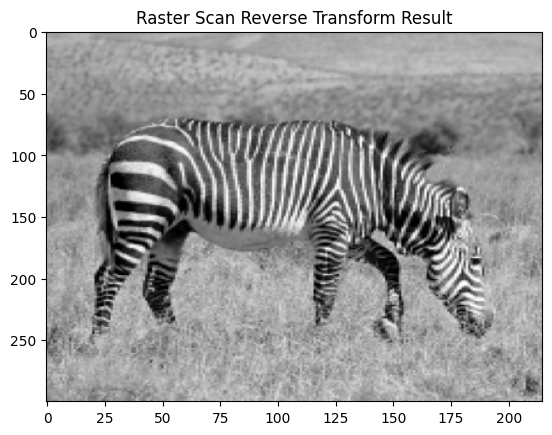

In [177]:
# Here, we apply Raster Scan Reverse Transform on our input image
print("=======COMMENCING RASTERIZATION=========")

# Make the image of homogenous coordinates
img_homog_coord = get_homogenous_img_coordinates(img)
img_color_map = img.flatten()

# Recall the same manual homography matrix from before
transformation_matrix = np.array([[-6.26446174e-02, -6.97407299e-01,  1.80277025e+02],
                                  [-2.13906092e+00, -2.07381974e+00,  6.88118138e+02],
                                  [-2.40391653e-03, -1.96483835e-03,  1.00000000e+00]])

raster_scan_reverse_transform(img, img_homog_coord, img_color_map, transformation_matrix)

# It seems that our raster scan reverse transform does not work as intended since we are getting an
# image that is flat...

# We expect an image that is tilted in the 3D space (just like the image shown right before the transformation).
# We can see that the outputs from the homography vs. raster scan reverse transformations are not the same...

# We can continue to explore how to improve our Raster Scan Reverse Transform Function or we can abandon it for now.

#### Let's step away from our zebra for a minute, and recap what we have so far. 

We have created a demonstration consisting of a series of functions that enables us to apply a homography (a matrix transformation) on an image. 

We then created a raster scan reverse transformation process that enables us to recreate the original image from a transformed image with a transformation matrix. 

Here we will demonstrate an application of a homography matrix that relates to its current use in the real-world: to project the image viewed from one perspective into the reference frame of the image viewed from a different perspective. 

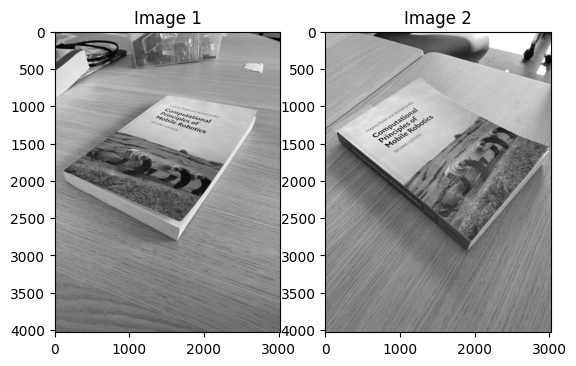

In [167]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
MIN_MATCH_COUNT = 10

img1 = cv.imread('images/book1.JPG', cv.IMREAD_GRAYSCALE) # read image from perspective 1
img2 = cv.imread('images/book2.JPG', cv.IMREAD_GRAYSCALE) # read image from perspective 2
fig, axes = plt.subplots(1, 2)

# Plot the two images side-by-side
axes[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
axes[0].set_title('Image 1')
axes[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
axes[1].set_title('Image 2')
plt.show()

# Initiate SIFT detector (this is a keypoint-detection method thats implication goes beyond
# the scope of this notebook.)
sift = cv.SIFT_create()
# Identify the keypoints (noteable features) between both images
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2) # Apply KNN algorithm to find possible matching features
# Store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.6*n.distance:
        good.append(m)

Now we will proceed to compute the homography matrix with a given number of matching features. This can be done in a variety of ways. OpenCV's cv.findHomography() function finds a 3x3 homography matrix using a combination of RANSAC and ordinary least-squares regression to find the most accurate homography matrix. Refer to this youtube video for a more detailed explanation of how the 3x3 homography matrix is estimated. 

https://youtu.be/l_qjO4cM74o?t=130

In [168]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0) # Compute Homography matrix using matching feature points
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

Let's plot the feature matches to see what's really going on. 

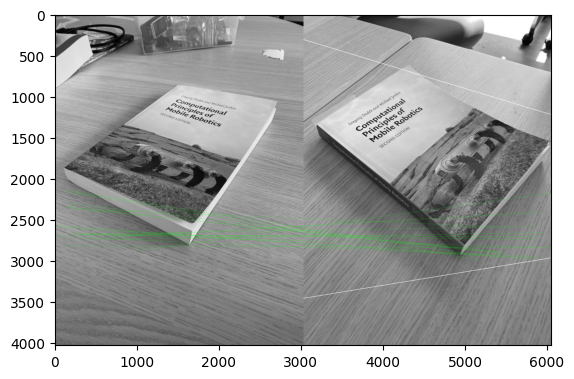

In [172]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params) # plot feature matches
plt.imshow(img3)

# The below code was me trying to play around with the non-openCV functions we wrote but 
# our plotting functions were noticeably worse for some reason. 

# img1_homog_coords = get_homogenous_img_coordinates(img1)
# img1_color_map = img1.flatten()
# img1_transformed = apply_transformation(img1_homog_coords, M)
# img1_transformed_2D = project_to_2D(img1_transformed)

# plot_image_2D(img1_transformed_2D, img1_color_map)

Now we can see how our homography matrix did, transforming image 1 into the perspective of image 2, by applying it onto image 1! Notice the black sections of the transformed image 1. This is expected, because our homography transformation never created new information about image 1 in the perspective of image 2, rather it only transformed image 1's existing pixels, resulting in an imperfect reconstruction in the new coordinate frame.

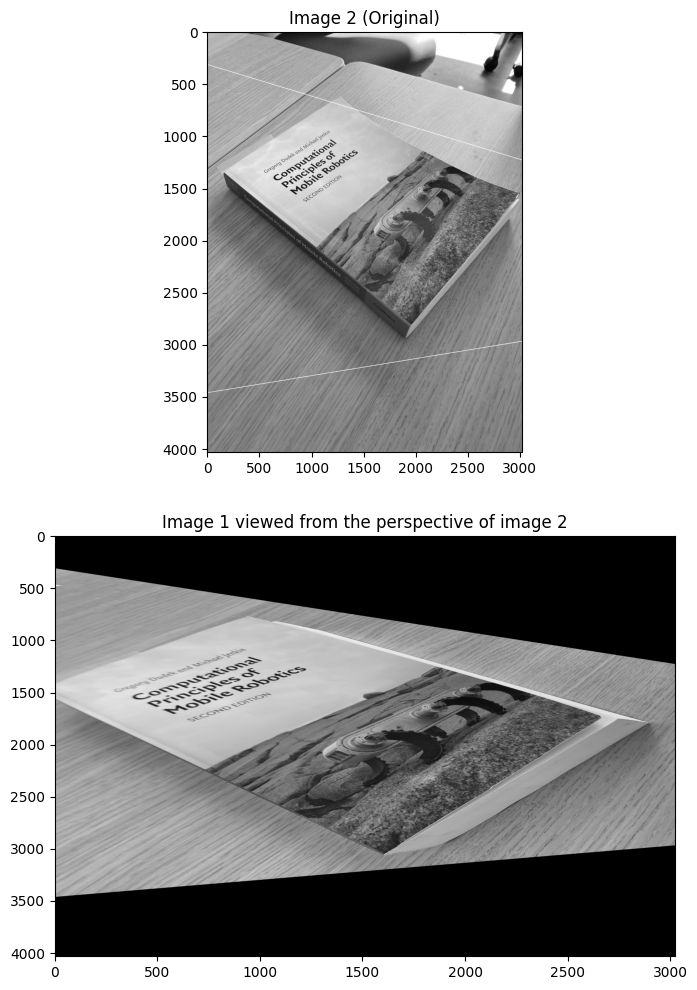

In [169]:
# draw_params = dict(matchColor = (0,255,0), # draw matches in green color
#                    singlePointColor = None,
#                    matchesMask = matchesMask, # draw only inliers
#                    flags = 2)

fig, axes = plt.subplots(2, 1, figsize=(8,12))
img1_warp = cv.warpPerspective(img1, M, (img1.shape[1], img1.shape[0]))
axes[0].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
axes[0].set_title('Image 2 (Original)')
# Plot the second image on the second subplot
axes[1].imshow(cv2.cvtColor(img1_warp, cv2.COLOR_BGR2RGB), aspect='auto')
axes[1].set_title('Image 1 viewed from the perspective of image 2')
plt.show()


#### Now, here are some other attempts we had using a gradient as our object of interest.

2D Gradient

X shape:  (100, 100)
Y shape:  (100, 100)
combined data shape:  (100, 100)
color:  (100, 100, 4)
New X Shape:  (10000,)
New Y Shape:  (10000,)
New Color Shape:  (10000, 4)


/var/folders/d3/d96wtgr52d7cwkj6vzkh__gc0000gp/T/ipykernel_39147/2851629216.py:43: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  _ = ax.scatter(x_new, y_new, c=color_new, cmap=custom_cmap, s=50, marker='o')


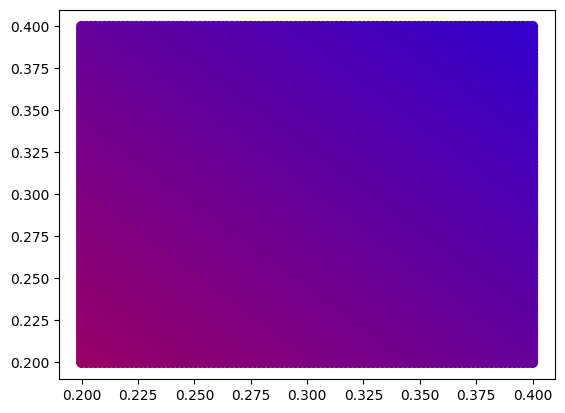

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import normalize

# Create a custom colormap
cmap_colors = [(0, 'red'), (1, 'blue'), (1, 'green')]                   # Colors for the combined dimension
custom_cmap = LinearSegmentedColormap.from_list('custom', cmap_colors)

# Create a 2D grid of values for both dimensions
num_dimensions = 2
lowest_color_value = 0.2
highest_color_value = 0.8

# Create the points that define our shape
x = np.linspace(lowest_color_value, highest_color_value/num_dimensions, 100)
y = np.linspace(lowest_color_value, highest_color_value/num_dimensions, 100)

X, Y = np.meshgrid(x, y)
print("X shape: ", X.shape)
print("Y shape: ", Y.shape)

# Combine data for both dimensions into a single variable
combined_data = X + Y                                       # You can use a different combination as needed
print("combined data shape: ", combined_data.shape)

# Apply the custom colormap to the combined data
color = custom_cmap(combined_data)
print("color: ", color.shape)

# Create a figure and axis
fig, ax = plt.subplots()

# Reshape x and y to match what is expected
x_new = X.reshape((-1,))
y_new = Y.reshape((-1,))
color_new = color.reshape((-1, 4))
print("New X Shape: ", x_new.shape)
print("New Y Shape: ", y_new.shape)
print("New Color Shape: ", color_new.shape)

# Plot the 2D grid with the colormap representing both dimensions
_ = ax.scatter(x_new, y_new, c=color_new, cmap=custom_cmap, s=50, marker='o')

# Show the plot
plt.show()

3D Gradient

In [37]:
# Define coordinate vectors (1D arrays)
x = np.array([0, 1, 2, 3])      # Change values as needed
y = np.array([10, 20, 30])      # Change values as needed

# Use np.meshgrid to create coordinate matrices
X, Y = np.meshgrid(x, y)

print("X (Coordinate Matrix for X):")
print(X)
print("Y (Coordinate Matrix for Y):")
print(Y)

X (Coordinate Matrix for X):
[[0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]]
Y (Coordinate Matrix for Y):
[[10 10 10 10]
 [20 20 20 20]
 [30 30 30 30]]


In [30]:
from skimage import transform
zebra_img = cv2.imread('images/Zebra_small.png')        # Load our source image, change if needed
zebra_img = cv2.cvtColor(zebra_img, cv2.COLOR_BGR2GRAY) # Convert to grayscale

# Resize the image if needed
resize_factor = 1.0
zebra_img = cv2.resize(zebra_img, (int(zebra_img.shape[0]*resize_factor), int(zebra_img.shape[1]*resize_factor)))

print(zebra_img.shape)

# The corners of the object of interest
src_2 = np.array([112, 200,                 # Source Coordinates
                  77, 200,
                  172, 48,
                  17, 53,]).reshape((4, 2))

# The corners we would like our object to positioned
dst_2 = np.array([50, 50,                   # Desired Transform Coordinates
                  50, 200,
                  150, 50,
                  150, 200,]).reshape((4, 2))

# Create plots
fig, ax = plt.subplots(2, 1, figsize=(6, 4))

ax[0].imshow(zebra_img,)
ax[0].scatter(src_2[:,0], src_2[:,1], c='red', s=30)
ax[0].set_title('Source Coordinates')

dst_2 = dst_2*2                                                     # Image sizes are not the same
tform = transform.estimate_transform('projective', src_2, dst_2)    # Apply projective transform
print("tform: ", tform)

tf_img = transform.warp(zebra_img, tform.inverse)                   # Apply warping to the image (using our estimated transformation)

print("tf_img.shape: ", tf_img.shape)
ax[1].imshow(tf_img)
ax[1].scatter(dst_2[:,0], dst_2[:,1], c='red', s=10)

ModuleNotFoundError: No module named 'skimage'